# Molecular evolution modeling
*Matthew Wakefield*

In this tutorial we are going to construct and assess a model of molecular evolution on a tree. To simplify the analysis we will use a specific simple tree shown below. 


```
         Sequence1            Sequence2
             \                   /
              \                 /
               \               /
 length = t1    \             / length = t2
                 \           /
                  \         /
                   \       /
                   Ancestral
```

This tree is used as it has the fundamental features that would be iterated over when implementing a pruning algorithm.

In [1]:
sequence1 = 'GATCGATCGATCGATCGATCGATCGATCGATCGATCGATC'
sequence2 = 'GATCGATCGATCGATCGATCGATCGATCGATCGATCGATC'

We are going to construct a Q matrix for the modeling. We do this using numpy, the numerical library for python, and use the array data structure.  This is by default floats.
As we will not be varying the mutation rate we dont need to keep remaking this matrix and it will be a constant in our calculations. Similarly because the JC69 assumes motif probabilities (base probabilities) are constant and equal we dont need to worry about varying them either. 

In [2]:
import numpy

In [3]:
mu=1
jc69Q = numpy.array([[-3.0*mu/4.0,     mu/4.0,     mu/4.0,     mu/4.0],
                     [     mu/4.0,-3.0*mu/4.0,     mu/4.0,     mu/4.0],
                     [     mu/4.0,     mu/4.0,-3.0*mu/4.0,     mu/4.0],
                     [     mu/4.0,     mu/4.0,     mu/4.0,-3.0*mu/4.0],
                    ])

In [4]:
jc69Q

array([[-0.75,  0.25,  0.25,  0.25],
       [ 0.25, -0.75,  0.25,  0.25],
       [ 0.25,  0.25, -0.75,  0.25],
       [ 0.25,  0.25,  0.25, -0.75]])

We will be multiplying the Q matrix by time (t) which is a scalar.

In [6]:
jc69Q*3

array([[-2.25,  0.75,  0.75,  0.75],
       [ 0.75, -2.25,  0.75,  0.75],
       [ 0.75,  0.75, -2.25,  0.75],
       [ 0.75,  0.75,  0.75, -2.25]])

When calculating the probability we will need to get a single column of the matrix as this will be the ancestral node probabilities. To make this easy we can create a dictionary corresponding to the matrix index.

In [5]:
jc69Q[0]

array([-0.75,  0.25,  0.25,  0.25])

In [6]:
base_index = {'A':0,'G':1,'C':2,'T':3,}

In [7]:
jc69Q[base_index['A']]

array([-0.75,  0.25,  0.25,  0.25])

In [9]:
# you can do multi dimensional lookups as well
jc69Q[base_index['A']][base_index['A']]

-0.75

To calculate the probability across our tree we need to calculate five probabilities, the probability at each of the three nodes and the transition probability at each of the two branches.
First we will calculate the probabilities of the tip nodes.

** Exercise 1:**

Calculate the log-probability of each of the two tip nodes.

The tip node probability is the product of the motif frequencies or $\pi$ for
each motif (i.e. each base in our sequence).  Under the Jukes-Cantor model this is the same for all
motifs A, C, G, and T, with pi = 1/4 for each.  When accumulating probabilities across sites we want to multiply probabilities. However it is better to 
log the probabilities to avoid underflow, and sum the
logs. We can then just keep the log of the probability.

*Hints: under this model the probabilities of seq1 and seq2 will be the same*

You will need numpy.log().

In [20]:
def log_pr_seq(seq):
    return numpy.log(0.25)*len(seq)

In [23]:
print(log_pr_seq(sequence1))
print(log_pr_seq(sequence2))
print(numpy.exp(log_pr_seq(sequence1)))
print(numpy.exp(log_pr_seq(sequence2)))

-55.4517744448
-55.4517744448
8.27180612553e-25
8.27180612553e-25


We now need to calculate the transition probability from each of the nodes, i.e. the matrix $P$. This is given by 

$$P = e^{tQ}$$

We need to calculate the product of tQ and the exponential of the resulting matrix. To calculate the exponential we will use the scipy.linalg.expm() function that uses the Padé approximation.

In [12]:
from scipy.linalg import expm

In [13]:
def make_transition_matrix(t, Q):
    return expm(t*Q)

You can see that after a very small time has passed, the chance of a base substitution is small (what do you expect to get if $t=0$?):

In [14]:
make_transition_matrix(0.01, jc69Q)

array([[ 0.99253738,  0.00248754,  0.00248754,  0.00248754],
       [ 0.00248754,  0.99253738,  0.00248754,  0.00248754],
       [ 0.00248754,  0.00248754,  0.99253738,  0.00248754],
       [ 0.00248754,  0.00248754,  0.00248754,  0.99253738]])

After a larger time has passed, the chance of a base substitution increases:

In [15]:
make_transition_matrix(2, jc69Q)

array([[ 0.35150146,  0.21616618,  0.21616618,  0.21616618],
       [ 0.21616618,  0.35150146,  0.21616618,  0.21616618],
       [ 0.21616618,  0.21616618,  0.35150146,  0.21616618],
       [ 0.21616618,  0.21616618,  0.21616618,  0.35150146]])

**Question:** What happens as you increase time `t` to larger and larger numbers? What does this mean?

Next we need to apply the probability matrix across the sequence. To do this we will need a function that calculates the transition probability matrix, and then processes the probabilities for each site in the sequence.

We will have two probabilites at the ancestral site, the probability of the transition to sequence1 and the probability of the transition to sequence2.
As we are interested in the probability for both data points we will multiply these probabilities to get the combined probability of sequence1 and sequence2 at that site.

If we know the motif at this site in the ancestral sequence, we can just multiply the probabilities:

In [15]:
# Leaf motifs (nucleotides)
motif1 = 'A'
motif2 = 'T'

# Ancestral motif
motif_ancestral = 'G'

# Branch lengths
t1 = 1
t2 = 1

# substitution rate matrix
Q=jc69Q

# Then we can calculate the probability of this data:

P1 = make_transition_matrix(t1,Q)
P2 = make_transition_matrix(t2,Q)

prob_substitution1 = P1[base_index[motif1], base_index[motif_ancestral]]
prob_substitution2 = P1[base_index[motif2], base_index[motif_ancestral]]
probability = prob_substitution1 * prob_substitution2

print(probability)

0.0249735250559


We don't actually know the ancestral sequence. We need to generate the probability for each possible alternative ancestral motif (A, C, G or T), and sum these probabilities to get the total probability of this model.

We can vectorise this efficiently with numpy's element-wise multiplication, by pulling the relevant rows out of `P1` and `P2` and multiplying them together:

In [18]:
P1[base_index[motif1]]

array([ 0.52590958,  0.15803014,  0.15803014,  0.15803014])

In [21]:
P2[base_index[motif2]]

array([ 0.15803014,  0.15803014,  0.15803014,  0.52590958])

In [20]:
P1[base_index[motif1]] * P2[base_index[motif2]]

array([ 0.08310956,  0.02497353,  0.02497353,  0.08310956])

In [22]:
# This is the sum over all possible ancestral motifs
sum(P1[base_index[motif1]] * P2[base_index[motif2]])

0.21616617919084685

Here's a function that puts that all together:

In [27]:
def get_site_probability(motif1, motif2, t1, t2, Q=jc69Q):
    base_index = {'A':0,'G':1,'C':2,'T':3,}
    P1 = make_transition_matrix(t1,Q)
    P2 = make_transition_matrix(t2,Q)
    return sum(P1[base_index[motif1]]*P2[base_index[motif2]])

In [25]:
get_site_probability('A','A',1,1)

0.35150146242745961

In [26]:
get_site_probability('A','T',1,1)

0.21616617919084685

The above gives the probability of the model for one motif (base) in the sequence.

To get the likelihood of the entire sequence we need to iterate over each site in the sequence, take the log and accumulate the sum of the logs. This is equivalent to just multiplying the probabilities, but more numerically stable.

In [30]:
def get_sequence_loglikelihood(seq1, seq2,
                               t1, t2,
                               Q=jc69Q):
    likelihood = 0
    assert len(seq1)==len(seq2)
    for i in range(len(seq1)):
        likelihood += numpy.log(
            get_site_probability(seq1[i],seq2[i],
                                 t1,t2,Q))
    # Technically we should multiply by tip probabilities too:
    #likelihood += log_pr_seq(seq1) + log_pr_seq(seq2)
    return likelihood

In [31]:
#This is a special case, identical sequences and zero branch length
get_sequence_loglikelihood('AAAA','AAAA',0,0)

0.0

In [88]:
get_sequence_loglikelihood('AAAA','AATA',0.1,0.1)

-3.5324468055704896

In [89]:
get_sequence_loglikelihood('AAAA','ACTA',0.1,0.1)

-6.480386086500874

The above code works as expected, however we end up doing lots of calls to the expensive expm function.

**Optional exercise:** Refactor the functions to reduce the number of calls to expm

**Exercise 2:**

Try some different sequences. Does it matter what the base changes are? If you have the same proportion of changes do you get the same results? Same proportion of conserved sites? What happens as the sequence gets longer? Does swapping t1 and t2 give the same likelihood result?


**Exercise 3:**

Plot the likelihood against t using a single value of t for both branch lengths. Do this for identical sequences and sequences with 25% difference.

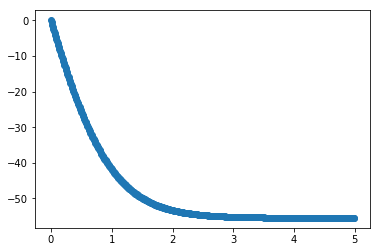

In [101]:
import matplotlib

lnLs = []
ts = []

for t in range(0,500):
    t= t/100.0
    ts.append(t)
    lnLs.append(get_sequence_loglikelihood(sequence1,
                                           sequence2,
                                           t,t))

matplotlib.pyplot.scatter(x=ts,y=lnLs)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


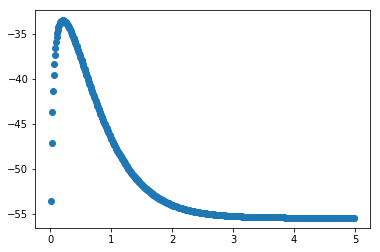

In [102]:
lnLs = []
ts = []

sequence3 = sequence2.replace('C','T')

for t in range(0,500):
    t= t/100.0
    ts.append(t)
    lnLs.append(get_sequence_loglikelihood(sequence1,
                                           sequence3,
                                           t,t))

matplotlib.pyplot.scatter(x=ts,y=lnLs)

